In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

# Prepare data

In [2]:
data = pd.read_csv("performance_year_financial_and_quality_results_puf_2020_01_01.csv")

In [13]:
vars_to_include = ['Agree_Type', 'Agreement_Period_Num', 'Risk_Model', 'SNF_Waiver',
                  'N_AB', 'Sav_rate', 'MinSavPerc', 'DisAffQual', 'Met_QPS', 'QualScore', 'RecvdMean',
                  'RegTrndUpdt', 'UpdatedBnchmk', 'HistBnchmk', 'ABtotExp', 'QualPerfShare', 
                   'FinalShareRate', 'Rev_Exp_Cat', 'Per_Capita_Exp_ALL_ESRD_PY', 'Per_Capita_Exp_ALL_DIS_PY',
                  'Per_Capita_Exp_ALL_AGDU_PY', 'Per_Capita_Exp_ALL_AGND_PY', 'Per_Capita_Exp_TOTAL_PY', 'N_AB_Year_PY',
                  'N_AB_Year_ESRD_PY', 'N_AB_Year_DIS_PY', 'N_AB_Year_AGED_Dual_PY', 'N_AB_Year_AGED_NonDual_PY',
                  'N_Ben_Age_0_64', 'N_Ben_Age_65_74', 'N_Ben_Age_75_84', 'N_Ben_Age_85plus', 'N_Ben_Male', 'N_Ben_Female', 
                   'CapAnn_INP_All', 'CapAnn_OPD', 'ADM_L_Trm', 'ADM_Rehab', 'ADM_Psych', 'chf_adm', 'copd_adm', 
                   'prov_Rate_1000', 'P_EDV_Vis', 'P_EDV_Vis_HOSP', 'P_CT_VIS', 'P_MRI_VIS', 'P_EM_Total', 'P_EM_SP_Vis',
                  'P_Nurse_Vis', 'P_FQHC_RHC_Vis', 'P_SNF_ADM', 'N_CAH', 'N_FQHC',
                  'N_RHC', 'N_ETA', 'N_Hosp', 'N_Fac_Other', 'N_PCP', 'N_Spec', 'N_NP', 'N_PA', 'N_CNS']

data_mod = data[vars_to_include]

dummy_cols = pd.get_dummies(data_mod[["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]], drop_first=True)
data_mod[dummy_cols.columns] = dummy_cols
data_mod.drop(["Rev_Exp_Cat", "Risk_Model", "Agree_Type"], axis=1, inplace=True)

X = data_mod.drop(['Sav_rate'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

In [21]:
#all of these are directly tied to the response variable and as such we do not want them as predictors
vars_to_exclude = ["EarnSaveLoss", "GenSaveLoss", "BnchmkMinExp", 'Current_Track_1', 'Current_Track_2', 'Current_Track_3',
                   'Current_Track_1_Plus', 'Current_BASIC_A', 'Current_BASIC_B', 'Current_BASIC_C', 'Current_BASIC_D',
                   'Current_BASIC_E', 'Current_ENHANCED', 'Adv_Pay', 'RevLossLimit'] 
data_mod = data.drop(vars_to_exclude, axis=1)

#Drop non-relevant categorial columns
cat_cols_to_encode = ["Rev_Exp_Cat", "Risk_Model", "Agree_Type"]
cols = data_mod.columns
num_cols = data_mod._get_numeric_data().columns
vars_to_exclude = list(set(cols) - set(num_cols) - set(cat_cols_to_encode))
data_mod = data_mod.drop(vars_to_exclude, axis=1)

#one-hot encode relevant categorial columns
data_mod = pd.get_dummies(data_mod, columns=cat_cols_to_encode)

nans = ['DisAdj', 'PosRegAdj', 'Adv_Pay_Amt','Adv_Pay_Recoup']
data_mod = data_mod.drop(nans, axis=1)

X = data_mod.drop(['Sav_rate', 'Risk_Model_One-Sided'], axis=1)
y = data_mod['Sav_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=34)

# PCA

In [4]:
# scale data for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# Perform PCA
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [49]:
X_train_pca[ : , :20].shape

(410, 20)

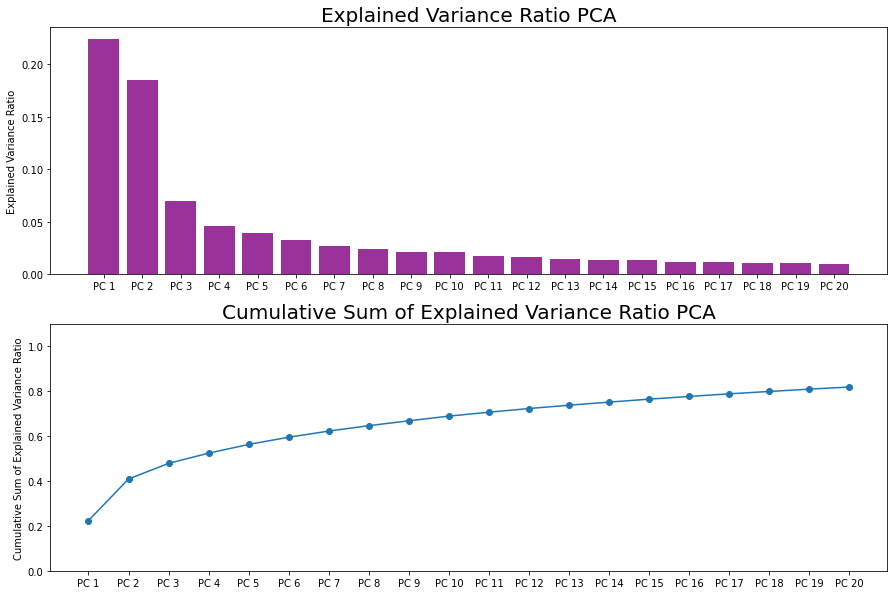

In [50]:
# Plot explained variance for pca components
fig, ax = plt.subplots(nrows=2, figsize=(15,10))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
num_components = 20
ax1.bar(range(num_components), ratio[ :num_components], color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(num_components))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(num_components)])
ax1.set_ylabel('Explained Variance Ratio')

ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio[ :num_components]), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(num_components))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(num_components)])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

# Single tree

In [31]:
max_depth = 40
cv_train_r2 = []
cv_val_r2 = []
cv_val_std = []
cv_train_mse = []
cv_test_mse = []

for tree_depth in range(1, max_depth+1):
    tree_model = DecisionTreeRegressor(max_depth=tree_depth, random_state=32)
    tree_model.fit(X_train, y_train)
    
    mse_score = cross_validate(DecisionTreeRegressor(max_depth=tree_depth, random_state=32), X_train, y_train, 
                               scoring='neg_mean_squared_error', cv=10, return_estimator=True, return_train_score=True)
    
    cv_train_mse.append(abs(mse_score['train_score']).mean())
    cv_test_mse.append(abs(mse_score['test_score']).mean())
    
    r2_train = []
    r2_validation = []
    for model in mse_score['estimator']:
        r2_train.append(model.score(X_train, y_train))
        r2_validation.append(model.score(X_test, y_test))
    
    cv_train_r2.append(np.mean(r2_train))
    cv_val_r2.append(np.mean(r2_validation))
    cv_val_std.append(np.std(r2_validation))

(-1.4896012651639225, 0.3648667735730887)

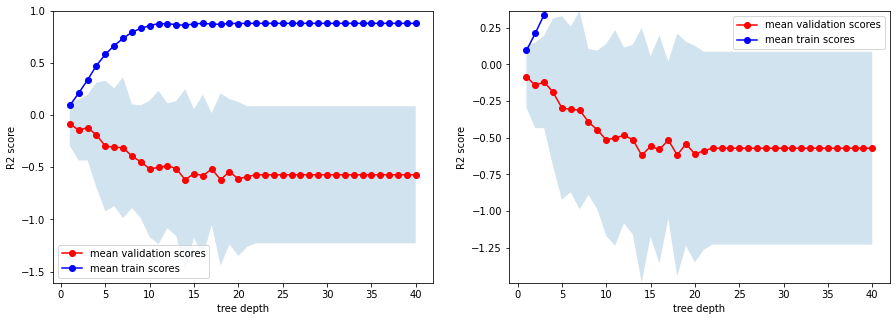

In [26]:
figure, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

for i in range(2):
    axs[i].plot(range(1, max_depth+1), cv_val_r2, 'o-', label='mean validation scores', color='r')
    axs[i].plot(range(1, max_depth+1), cv_train_r2, 'o-', label='mean train scores', color='b')
    axs[i].fill_between(range(1, max_depth+1), [a + 2*b for a, b in zip(cv_val_r2, cv_val_std)], [a - 2*b for a, b in zip(cv_val_r2, cv_val_std)], alpha=0.2)
    axs[i].set(xlabel='tree depth', ylabel='R2 score')
    axs[i].legend()
axs[1].set_ylim(min([a - 2*b for a, b in zip(cv_val_r2, cv_val_std)]), max([a + 2*b for a, b in zip(cv_val_r2, cv_val_std)]))

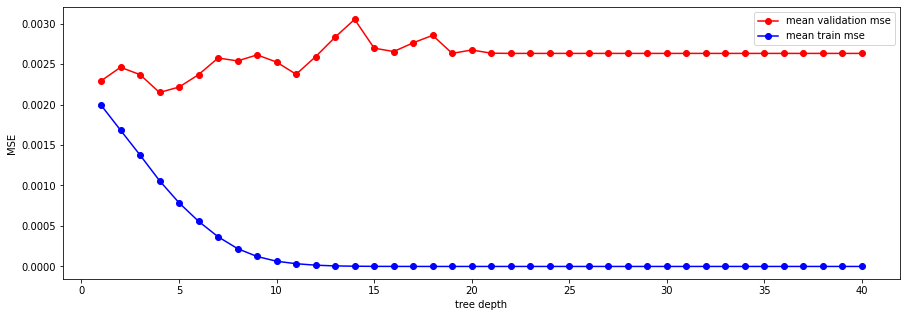

In [33]:
figure, ax = plt.subplots(figsize=(15,5))

ax.plot(range(1, max_depth+1), cv_test_mse, 'o-', label='mean validation mse', color='r')
ax.plot(range(1, max_depth+1), cv_train_mse, 'o-', label='mean train mse', color='b')
ax.set(xlabel='tree depth', ylabel='MSE')
ax.legend()

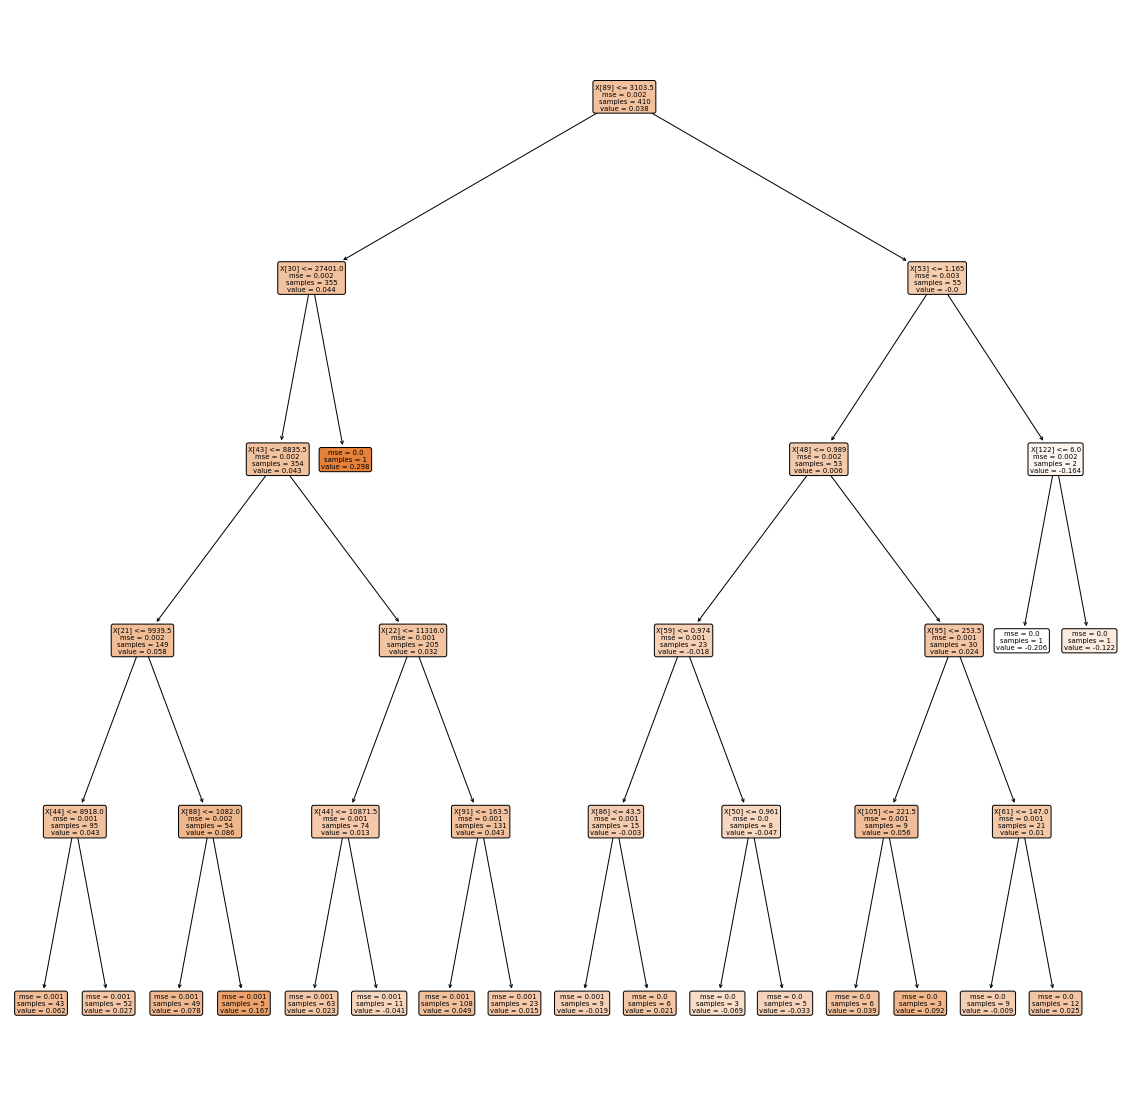

In [41]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=32)
tree_model.fit(X_train, y_train)

figure, ax = plt.subplots(figsize=(20, 20))

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(tree_model, filled=True, rounded=True, ax=ax)

plt.savefig('Project_images/decision_tree.pdf', bbox_inches="tight")

In [45]:
print(X_train.columns[89], X_train.columns[30], X_train.columns[53])

CapAnn_OPD Per_Capita_Exp_ALL_AGDU_BY1 CMS_HCC_RiskScore_ESRD_BY3


# Random Forest

In [51]:
max_depth = 40
cv_train_r2 = []
cv_val_r2 = []
cv_val_std = []
cv_train_mse = []
cv_test_mse = []

for tree_depth in range(1, max_depth+1):
    tree_model = RandomForestRegressor(max_features='sqrt', max_depth=tree_depth, random_state=32)
    tree_model.fit(X_train, y_train)
    
    mse_score = cross_validate(RandomForestRegressor(max_features='sqrt', max_depth=tree_depth, random_state=32), X_train, 
                               y_train, scoring='neg_mean_squared_error', cv=10, return_estimator=True, return_train_score=True)
    
    cv_train_mse.append(abs(mse_score['train_score']).mean())
    cv_test_mse.append(abs(mse_score['test_score']).mean())
    
    r2_train = []
    r2_validation = []
    for model in mse_score['estimator']:
        r2_train.append(model.score(X_train, y_train))
        r2_validation.append(model.score(X_test, y_test))
    
    cv_train_r2.append(np.mean(r2_train))
    cv_val_r2.append(np.mean(r2_validation))
    cv_val_std.append(np.std(r2_validation))

(0.031190265987276915, 0.4539898048673513)

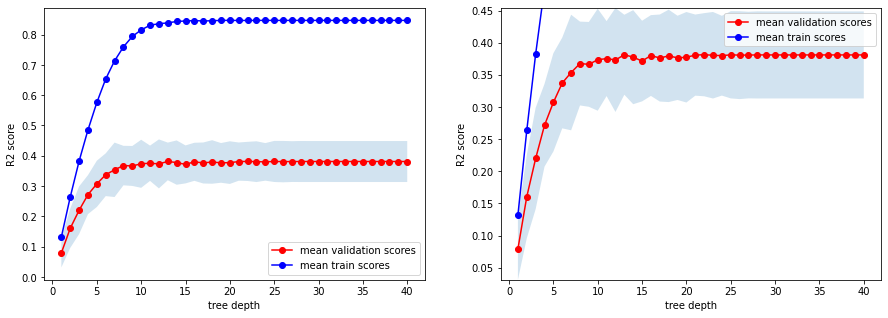

In [52]:
figure, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

for i in range(2):
    axs[i].plot(range(1, max_depth+1), cv_val_r2, 'o-', label='mean validation scores', color='r')
    axs[i].plot(range(1, max_depth+1), cv_train_r2, 'o-', label='mean train scores', color='b')
    axs[i].fill_between(range(1, max_depth+1), [a + 2*b for a, b in zip(cv_val_r2, cv_val_std)], [a - 2*b for a, b in zip(cv_val_r2, cv_val_std)], alpha=0.2)
    axs[i].set(xlabel='tree depth', ylabel='R2 score')
    axs[i].legend()
axs[1].set_ylim(min([a - 2*b for a, b in zip(cv_val_r2, cv_val_std)]), max([a + 2*b for a, b in zip(cv_val_r2, cv_val_std)]))

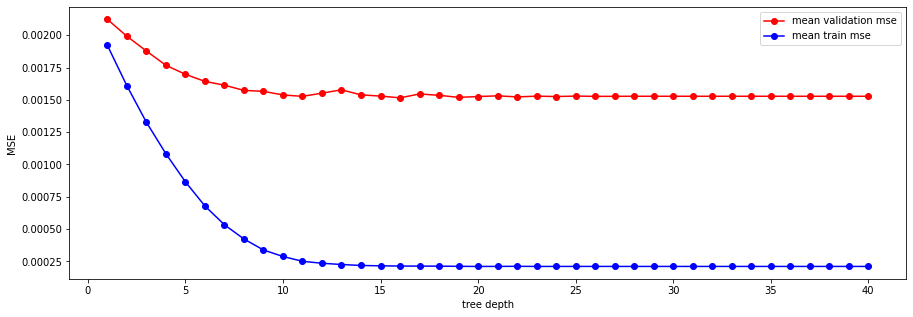

In [53]:
figure, ax = plt.subplots(figsize=(15,5))

ax.plot(range(1, max_depth+1), cv_test_mse, 'o-', label='mean validation mse', color='r')
ax.plot(range(1, max_depth+1), cv_train_mse, 'o-', label='mean train mse', color='b')
ax.set(xlabel='tree depth', ylabel='MSE')
ax.legend()

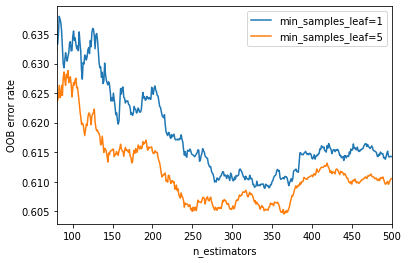

Wall time: 1min 41s


In [64]:
%%time
from collections import OrderedDict
ensemble_clfs = [
    (1,
        RandomForestRegressor(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth = 12,
                               random_state=32)),
    (5,
        RandomForestRegressor(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth = 12,
                               random_state=32))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(X_train.values, y_train.values)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show();


Random Forest Training Score: 0.894
Random Forest Test Score: 0.402


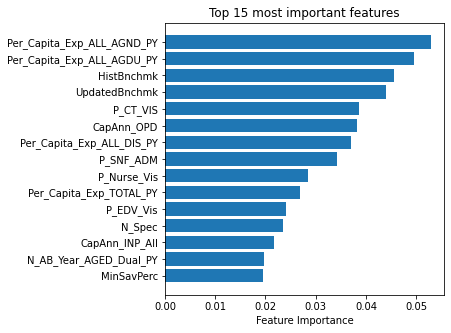

In [14]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', max_depth=12, random_state=32, n_estimators=275)
rf.fit(X_train, y_train)

print(f"Random Forest Training Score: {rf.score(X_train, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test, y_test):.3f}")

# Find most important feautres
cols = X.columns
feat_importances = rf.feature_importances_

importance, features = (list(t) for t in zip(*sorted(zip(feat_importances, cols))))

figure, ax = plt.subplots(figsize=(5,5))

num_features = 15
ax.barh(np.arange(num_features), importance[-num_features: ], align='center', tick_label=features[-num_features: ])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 most important features')

plt.show()

In [5]:
#pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [6]:
import eli5
from eli5.sklearn import PermutationImportance

In [15]:
perm = PermutationImportance(rf, random_state=32, n_iter=15).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0635 ± 0.0257,Per_Capita_Exp_ALL_AGDU_PY
0.0491 ± 0.0281,HistBnchmk
0.0450 ± 0.0425,Per_Capita_Exp_ALL_AGND_PY
0.0447 ± 0.0401,UpdatedBnchmk
0.0393 ± 0.0190,P_SNF_ADM
0.0214 ± 0.0314,Per_Capita_Exp_ALL_DIS_PY
0.0206 ± 0.0184,P_Nurse_Vis
0.0200 ± 0.0258,Risk_Model_Two-Sided
0.0185 ± 0.0153,MinSavPerc
0.0143 ± 0.0140,Per_Capita_Exp_TOTAL_PY


# Random Forest with PCA

In [61]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', max_depth=12, random_state=32, n_estimators=275)
rf.fit(X_train_pca, y_train)

print(f"Random Forest Training Score: {rf.score(X_train_pca, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test_pca, y_test):.3f}")

Random Forest Training Score: 0.868
Random Forest Test Score: 0.287


# Random Forest with scaled variables

In [5]:
# Create and train Random Forest Regressor
rf = RandomForestRegressor(max_features='sqrt', max_depth=12, random_state=32, n_estimators=275)
rf.fit(X_train_scaled, y_train)

print(f"Random Forest Training Score: {rf.score(X_train_scaled, y_train):.3f}")
print(f"Random Forest Test Score: {rf.score(X_test_scaled, y_test):.3f}")

Random Forest Training Score: 0.893
Random Forest Test Score: 0.404
